In [1]:
%matplotlib inline
%matplotlib widget
#%matplotlib notebook
import json
import os
import pprint
import datetime as dt
from matplotlib import pyplot as plt
from matplotlib.container import BarContainer

import numpy as np
import math
import pandas as pd
import textwrap

import ipywidgets as widgets
from ipywidgets import Label, HBox, VBox, Button, HTML
from ipywidgets import interact, interact_manual, Layout
import IPython.display
from IPython.display import display, clear_output
import mplcursors
from matplotlib.legend_handler import HandlerLine2D
from collections import Counter
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates 
import copy
from matplotlib.dates import DateFormatter
plt.style.use('seaborn-notebook')


from query import * 
from dataframe_visualization import *
#import plotly.graph_objects as go

In [2]:
# dataframe을 얻기 위함
import matplotlib

df = sns.load_dataset('iris')

#grid = sns.FacetGrid(df, col = 'species', margin_titles = True)
#grid.map(sns.lmplot, 'species', 'sepal_length', fit_reg = False)

#sns.displot(df, x ='sepal_width',y = 'sepal_length', kind ='line')
# df = q("""SELECT
#     EVENT_NAME,
#     MAX_TIMER_READ,
#     AVG_TIMER_READ,
#     MAX_TIMER_WRITE,
#     AVG_TIMER_WRITE,
#     MAX_TIMER_MISC,
#     AVG_TIMER_MISC
#     FROM performance_schema.file_summary_by_event_name;
# """)

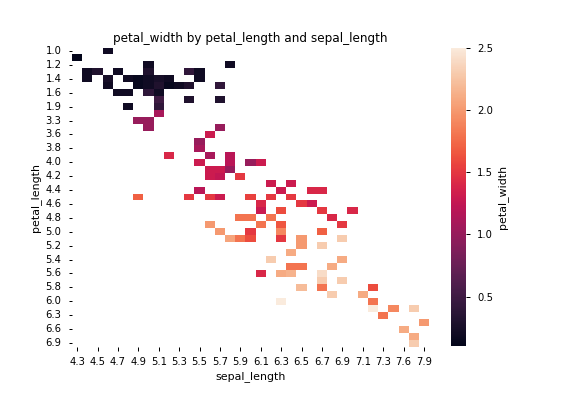

In [3]:
#VBox([Label('I want this to be in the center.')]
#,layout=Layout(width='100%', display='flex' ,
#align_items='center'))


def visualize(df = None, user_query = ""):
    line = HTML('<hr>')
    col_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='center',
                    #border='solid',
                    width='50%')
    row_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='center',
                    align_content = 'stretch',
                    justify_content = 'center',


                    #border='solid',
                    width='100%')
    
    head = HTML(value="<b><font size = 5> Visualization Mode</b>")
    head1 = HTML(value="<font size = 3> General Visualization")
    head2 = HTML(value="<font size = 3> Specialized Visualization")
    b11= Button(description="Query and Visualize")
    b12= Button(description="Dataframe Visualizer")
    b21= Button(description="Metric Viewer")
    b22= Button(description="Query Performance Viewer")
    b23= Button(description="Wait Time Viewer")
    def b11_on_click_callback(clicked_button: widgets.Button) -> None:
        b11_head = HTML(value="<b><font size = 3> Query and Visualize")
        rb = widgets.RadioButtons(
                    options=['w/ template', 'w/o template'],
                    description='Query Mode:',
                    disabled=False
                )
        b11_button = Button(description="Ok", button_style ='primary')
        def query_on_click_callback(b):
            if rb.value == 'w/ template':
                get_query_template()
            elif rb.value == 'w/o template':
                if user_query != "":
                    q(user_query)
                else:
                    text = widgets.Text(description='Query:', disabled=False)
                    text_button = Button(description = "Enter")
                    display(HBox([text, text_button]))
                    def text_button_on_click_callback(tb):
                        if len(text.value)>0:
                            q(text.value)
                    text_button.on_click(text_button_on_click_callback)
                
        b11_button.on_click(query_on_click_callback)
        display(VBox([line, b11_head, HBox([rb, b11_button])]))
        
    button_box1 = HBox([b11,b12], layout = row_layout)
    button_box2 = HBox([b21,b22,b23],  layout = row_layout)
    #Label("Visualization Mode", style = dict(font_weight='bold',font_size="18px"))
    
    b11.on_click(b11_on_click_callback)
                 
                 
    def b12_on_click_callback(clicked_button: widgets.Button) -> None:
        assert df is not None, '[Error] Dataframe input is required to visualize dataframe !'
        dataframe_visualization(df)

    b12.on_click(b12_on_click_callback)
    display(VBox([head, head1,button_box1, head2, button_box2],layout = col_layout))

    
visualize(df)



In [2]:
def get_column(path) -> dict:

    path = 'data_temp'
    file_list = os.listdir(path)
    remove_list = []
    filename = file_list[0]
    file_datetime = dt.datetime.strptime(filename,'%Y%m%d_%H%M%S') 
    #print(os.path.join(path, filename))
    with open(os.path.join(path, filename), 'r') as f:
        # 파일 내를 탐색
        text = json.load(f)

    metrics_data = text['metrics_data']['global']['global']
    metrics = list(text['metrics_data']['global']['global'].keys())
    # 이상한 metric들 제거
    for me in metrics:
        if metrics_data[me].isdigit():
            pass
        else:
            remove_list.append(me)

    metrics= [x for x in metrics if x not in remove_list]
    innodb_metrics = list(text['metrics_data']['global']['innodb_metrics'].keys())
    derived_metrics = list(text['metrics_data']['global']['derived'].keys())
    resource_metrics = list(text['metrics_data']['global']['engine']['innodb_status_io'].keys())
    resource_metrics.append('cpu')
    wait_metrics = list(text['metrics_data']['global']['wait'].keys())

    column = {}
    column['metrics'] = metrics
    column['innodb_metrics'] = innodb_metrics
    column['derived_metrics'] = derived_metrics
    column['resource_metrics'] = resource_metrics
    column['wait'] = wait_metrics
    return column

def create_dataframe(col):
    metrics = {}
    metrics['metrics'] = pd.DataFrame(columns = col['metrics'])
    metrics['innodb_metrics'] = pd.DataFrame(columns = col['innodb_metrics'])
    metrics['derived_metrics'] = pd.DataFrame(columns = col['derived_metrics'])
    metrics['resource_metrics'] = pd.DataFrame(columns = col['resource_metrics'])
    metrics['wait'] = pd.DataFrame(columns = col['wait'])
    
    
    return metrics

def import_metrics(metrics, text, timestamp,col):
    metrics_data = text['metrics_data']['global']['global']
    new_row = {}
    for m in col['metrics']:
        new_row[m] = metrics_data[m]
    metrics['metrics'] = metrics['metrics'].append(new_row,ignore_index=True)
   
    innodb_metrics_data = text['metrics_data']['global']['innodb_metrics']
    new_row = {}
    for m in col['innodb_metrics']:
        new_row[m] = innodb_metrics_data[m]
    metrics['innodb_metrics'] = metrics['innodb_metrics'].append(new_row,ignore_index=True)
    
    derived_metrics_data = text['metrics_data']['global']['derived']
    new_row = {}
    for m in col['derived_metrics']:
        new_row[m] = derived_metrics_data[m]
    metrics['derived_metrics'] = metrics['derived_metrics'].append(new_row,ignore_index=True)
    
    resource_metrics_data = text['metrics_data']['global']['engine']['innodb_status_io']
    new_row = {}
    new_row['data_io'] = resource_metrics_data['data_io']
    new_row['log_io'] = resource_metrics_data['log_io']
    new_row['cpu'] = text['metrics_data']['global']['cpu']
    metrics['resource_metrics'] = metrics['resource_metrics'].append(new_row,ignore_index=True)
    
    wait_metrics_data = text['metrics_data']['global']['wait']
    
    metrics['wait'] = metrics['wait'].append(wait_metrics_data, ignore_index = True)
    
    
    return metrics

In [3]:
class digest_query:
    def __init__(self, query_id, digest, digest_text, time_ms, cpu_usage, io, count, timestamp):
        self.query_id = query_id
        self.digest = digest
        self.digest_text = digest_text
        self.value = [[timestamp, time_ms, cpu_usage, io, count]]
        self.time_ms = []
        self.cpu_usage = []
        self.io = []
        self.count = []
        self.timestamp = []
    
    def add_time(self, time_ms):
        self.value[-1][1]+=time_ms
    
    def add_timestamp(self, time_ms, cpu_usage, io, count, timestamp):
        self.value.append([timestamp, time_ms, cpu_usage, io, count])
    
    def print_digest_query(self):
        print(f'query_id={self.query_id}')
        print(f'digest={self.digest}')
        print(f'digest_text={self.digest_text}')
        print(f'time_ms={self.time_ms}')
        print(f'cpu_usage={self.cpu_usage}')
    
    def sort_timestamp(self):
        self.value = list(map(lambda x: [x[0], float(x[1]), float(x[2]), int(x[3]), int(x[4])], self.value))
        self.value = sorted(self.value, key=lambda x:x[0])
        for v in self.value:
            #print(v)
            self.time_ms.append(v[1]) 
            self.cpu_usage.append(v[2])
            self.timestamp.append(v[0])
            self.count.append(v[4])
            self.io.append(v[3])

    def add_missing_value(self, all_timestamp):
        new_time_ms = []
        new_cpu_usage = []
        new_count = []
        new_io = []
        for time in all_timestamp:
            if time in self.timestamp: #b에서 val의 index
                
                new_time_ms.append(self.time_ms[self.timestamp.index(time)])
                new_cpu_usage.append(self.cpu_usage[self.timestamp.index(time)])
                new_count.append(self.count[self.timestamp.index(time)])
                new_io.append(self.io[self.timestamp.index(time)])
            else:
                new_time_ms.append(0)
                new_cpu_usage.append(0)
                new_count.append(0)
                new_io.append(0)
        #print(len(all_timestamp), len(new_time_ms), len(new_cpu_usage))
        self.time_ms = new_time_ms
        self.cpu_usage = new_cpu_usage
        self.count = new_count
        self.io = new_io
        
        self.timestamp = copy.deepcopy(all_timestamp)

    
    def merge(self, other_query): #other query가 반드시 더 새로 수집된 데이터로부터 구한 거라고 가정!!
        self.time_ms += other_query.time_ms
        self.cpu_usage += other_query.cpu_usage
        self.io += other_query.io
        self.count += other_query.count
        self.timestamp += other_query.timestamp
        
def update_data(path, dic, metrics,all_timestamp, last_import_timestamp, query_num, col):
    new_dic = {}
    new_timestamp =[]
    file_list = os.listdir(path)
    
    min_datetime = dt.datetime.now()

    count = 0
    for filename in file_list:
        file_datetime = dt.datetime.strptime(filename,'%Y%m%d_%H%M%S') 
        if file_datetime <=last_import_timestamp:
            continue
        else:
            count+=1
            if count%10 ==0:
                print(file_datetime)
            if min_datetime > file_datetime:
                min_datetime = file_datetime
        with open(os.path.join(path, filename), 'r') as f:
            # 같은 파일 내를 탐색
            new_timestamp.append(file_datetime)
            text = json.load(f)
            metrics = import_metrics(metrics, text, file_datetime, col)
            #io = text['metrics_data']["global"]["engine"]["innodb_status_io"]
            performance_schema = text['metrics_data']['global']['performance_schema']

            threads = performance_schema['threads']       
            tid_dic = {i[0]['thread_id']:i[0]['thread_os_id'] for i in threads}
            cpu_usage = performance_schema['cpu_usage'] # thread_os_id : cpu_usage
            io = performance_schema['io'] 
            events_statements_history = performance_schema['events_statements_history'] # list of dic
            digest_list = []
            for event in events_statements_history:
                digest = event['digest']
                if digest is None:
                    continue
                #print(category(digest))
                thread_id = event['thread_id']
                digest_text = event['digest_text']
                count = event['count']
                time = event['time_ms']
                if digest in digest_list: # 같은 쿼리가 같은 시간대에 이미 존재할 경우? time만 합친다.
                    new_dic[digest].add_time(time)
                elif digest in new_dic.keys():
                    if str(tid_dic[thread_id]) in io.keys():
                        #io key에는 있는데 cpu key에는 없을때 ??????? 없을 수도 있음 그러면 0으로 때리자
                        if str(tid_dic[thread_id])  not in cpu_usage.keys():
                            new_dic[digest].add_timestamp(time, 0, io[str(tid_dic[thread_id])], count, file_datetime)
                        else:
                            new_dic[digest].add_timestamp(time, cpu_usage[str(tid_dic[thread_id])], io[str(tid_dic[thread_id])], count, file_datetime)
                    else:
                        if str(tid_dic[thread_id])  not in cpu_usage.keys():
                            new_dic[digest].add_timestamp(time, 0, 0, count, file_datetime)
                        else:
                            new_dic[digest].add_timestamp(time, cpu_usage[str(tid_dic[thread_id])], 0, count, file_datetime)
                else:
                    if str(tid_dic[thread_id]) in io.keys():
                        if str(tid_dic[thread_id]) not in cpu_usage:
                            temp = digest_query(query_num, digest, digest_text, time, 0, io[str(tid_dic[thread_id])], count, file_datetime)
                        else:
                            temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dic[thread_id])], io[str(tid_dic[thread_id])], count, file_datetime)
                    else:
                        if str(tid_dic[thread_id]) not in cpu_usage:
                            temp = digest_query(query_num, digest, digest_text, time, 0, 0, count, file_datetime)
                        else:
                            temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dic[thread_id])], 0, count, file_datetime)
                    #key error 발생
                    new_dic[digest] = temp
                    query_num+=1

                digest_list.append(digest)
    new_timestamp.sort()
    for query in new_dic:
        query_id = new_dic[query].query_id
        new_dic[query].sort_timestamp()
    #print(len(digest_list))
    
    add_digest_list = copy.deepcopy(digest_list)
    
    for new_query in digest_list: # 새로 추가된 digest = 즉, dict의 key, merge 할때마다 list에서 제거할것
        if new_query in dic.keys():
            dic[new_query].merge(new_dic[new_query])
            add_digest_list.remove(new_query)
    
    #print(len(digest_list))
    for new_digest in add_digest_list:
        dic[new_digest] = new_dic[new_digest]
    #print("all_timestamp before add",len(all_timestamp))
    all_timestamp+=new_timestamp
    #print("all_timestamp aft add",len(all_timestamp))
    for query in dic:
        dic[query].add_missing_value(all_timestamp)
        #print(len(dic[query].time_ms))
    print("MINDT : ",min_datetime)
    return dic, metrics, all_timestamp, query_num
                            
def Average(lst):
        return sum(lst) / len(lst)    

def import_data(path, time_range=dt.timedelta(hours=1)):
    dic = {}
    query_num = 0
    all_timestamp =[]
    file_list = os.listdir(path)#[:10] # for debug
    max_datetime = dt.datetime.min
    
    col = get_column(path)
    metrics = create_dataframe(col)
    count = 0
    #print(col)
    
    for filename in file_list:
        file_datetime = dt.datetime.strptime(filename,'%Y%m%d_%H%M%S') 
        if realtime == True and file_datetime <= dt.datetime.now() - time_range:
            print(file_datetime)
            if max_datetime < file_datetime:
                max_datetime = file_datetime
            continue
        else:
            print("imported")
            count+=1
            if count%10 ==0:
                print(file_datetime)
            print(file_datetime)
            if max_datetime < file_datetime:
                max_datetime = file_datetime
        with open(os.path.join(path, filename), 'r') as f:
            # 같은 파일 내를 탐색
            all_timestamp.append(file_datetime)
            text = json.load(f)
            metrics = import_metrics(metrics, text, file_datetime, col)
            #print(metrics)
            #io = text['metrics_data']["global"]["engine"]["innodb_status_io"]
            performance_schema = text['metrics_data']['global']['performance_schema']
            threads = performance_schema['threads']       
            tid_dic = {i[0]['thread_id']:i[0]['thread_os_id'] for i in threads}
            cpu_usage = performance_schema['cpu_usage'] # thread_os_id : cpu_usage
            io = performance_schema['io'] 
            events_statements_history = performance_schema['events_statements_history'] # list of dic
            digest_list = []
            for event in events_statements_history:
                digest = event['digest']
                if digest is None:
                    continue
                thread_id = event['thread_id']
                digest_text = event['digest_text']
                count = event['count']
                time = event['time_ms']
                if thread_id not in tid_dic:
                    print(f'{thread_id} is not in tid_dic')
                    continue
                if digest in digest_list: # 같은 쿼리가 같은 시간대에 이미 존재할 경우? time만 합친다.
                    dic[digest].add_time(time)
                elif digest in dic.keys():
                    if str(tid_dic[thread_id]) in io.keys():
                        #io key에는 있는데 cpu key에는 없을때 ??????? 없을 수도 있음 그러면 0으로 때리자
                        if str(tid_dic[thread_id])  not in cpu_usage.keys():
                            dic[digest].add_timestamp(time, 0, io[str(tid_dic[thread_id])], count, file_datetime)
                        else:
                            dic[digest].add_timestamp(time, cpu_usage[str(tid_dic[thread_id])], io[str(tid_dic[thread_id])], count, file_datetime)
                    else:
                        if str(tid_dic[thread_id])  not in cpu_usage.keys():
                            dic[digest].add_timestamp(time, 0, 0, count, file_datetime)
                        else:
                            dic[digest].add_timestamp(time, cpu_usage[str(tid_dic[thread_id])], 0, count, file_datetime)
                else:
                    if str(tid_dic[thread_id]) in io.keys():
                        if str(tid_dic[thread_id]) not in cpu_usage:
                            temp = digest_query(query_num, digest, digest_text, time, 0, io[str(tid_dic[thread_id])], count, file_datetime)
                        else:
                            temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dic[thread_id])], io[str(tid_dic[thread_id])], count, file_datetime)
                    else:
                        if str(tid_dic[thread_id]) not in cpu_usage:
                            temp = digest_query(query_num, digest, digest_text, time, 0, 0, count, file_datetime)
                        else:
                            temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dic[thread_id])], 0, count, file_datetime)
                    #key error 발생
                    dic[digest] = temp
                    query_num+=1
                digest_list.append(digest)
    all_timestamp.sort()
    
    print("MAXDT : ",max_datetime)
    
    for query in dic:
        query_id = dic[query].query_id
        dic[query].sort_timestamp()
        dic[query].add_missing_value(all_timestamp)
    return dic, metrics, all_timestamp, query_num, col

def rank(dic, category, num, time_range):
    
    rank_list = []
    dic_by_id={}
    for query in dic:
        query_id = dic[query].query_id
        dic_by_id[query_id] = dic[query]
        i=0
        for i, t in enumerate(dic[query].timestamp):
            if t > dic[query].timestamp[-1] - time_range:
                #print(i)
                break
        rank_list.append((dic[query].query_id, Average(dic[query].time_ms[i:]), Average(dic[query].cpu_usage[i:]), Average(dic[query].io[i:]), Average(dic[query].count[i:])))
    
    if category == 'CPU':
        top = sorted(rank_list, key=lambda x:-x[2])[:num]
        print(top)
    elif category == 'Duration':
        top = sorted(rank_list, key=lambda x:-x[1])[:num]
    elif category == 'Disk IO':
        top = sorted(rank_list, key=lambda x:-x[3])[:num]
    elif category == 'Execution Count':
        top = sorted(rank_list, key=lambda x:-x[4])[:num]
    top_qid = [i[0] for i in top]
    return top_qid

In [4]:
#fig, ax = plt.subplots(figsize=(10, 7))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
realtime = False
path = "data_temp"
all_timestamp =[]
dic={}

if os.path.isfile('data_temp.pickle'):
    with open('data.pickle','rb') as fr:
        dic, metrics, all_timestamp, query_num, col, last_import_time = pickle.load(fr)
    print("Loaded Data from Pickle")
    dic, metrics, all_timestamp, query_num = update_data(path, dic, metrics,all_timestamp,last_import_time, query_num, col)
    last_import_time = dt.datetime.now()
    print(last_import_time)
    pickle_list = [dic, metrics, all_timestamp, query_num, col, last_import_time]
    with open('data.pickle','wb') as fw:
        pickle.dump(pickle_list,fw)
    print("Data Update Complete!")
else:
    dic, metrics, all_timestamp, query_num, col = import_data(path)
    print(dic)
    print(metrics)
    last_import_time = dt.datetime.now()
    print(last_import_time)
    print("Data Loading from json Complete!")
    pickle_list = [dic, metrics, all_timestamp, query_num, col, last_import_time]
    with open('data.pickle','wb') as fw:
        pickle.dump(pickle_list,fw)
    print("Saved Data into Pickle")

imported
2022-09-15 15:50:18
imported
2022-09-15 16:14:38
imported
2022-09-15 16:18:38
imported
2022-09-15 15:55:48
imported
2022-09-15 16:16:38
imported
2022-09-15 16:03:08
imported
2022-09-15 15:59:18
imported
2022-09-15 16:24:58
imported
2022-09-15 15:49:18
imported
2022-09-15 15:48:18
imported
2022-09-15 15:49:08
imported
2022-09-15 16:07:08
imported
2022-09-15 15:48:08
imported
2022-09-15 15:56:48
imported
2022-09-15 16:07:28
imported
2022-09-15 16:11:18
imported
2022-09-15 15:50:38
imported
2022-09-15 16:28:18
imported
2022-09-15 16:21:38
imported
2022-09-15 16:07:48
imported
2022-09-15 16:23:58
imported
2022-09-15 15:52:08
imported
2022-09-15 15:49:58
imported
2022-09-15 15:54:48
imported
2022-09-15 16:22:28
imported
2022-09-15 16:19:48
imported
2022-09-15 16:11:38
imported
2022-09-15 16:28:48
imported
2022-09-15 16:12:08
imported
2022-09-15 16:06:28
imported
2022-09-15 15:47:58
imported
2022-09-15 16:20:48
imported
2022-09-15 15:54:08
imported
2022-09-15 16:03:28
imported
2022-

Saved Data into Pickle


In [5]:

def resample(inp_array,window_size,how='avg'):
    inp_array = np.asarray(inp_array)
    #print(inp_array)
    #check how many zeros need to be added to the end to make
    #   the array length a multiple of window_size 
    pad = (window_size-(inp_array.size % window_size)) % window_size
    if pad > 0:
        inp_array = np.r_[np.ndarray.flatten(inp_array),np.zeros(pad)]
    else:
        inp_array = np.ndarray.flatten(inp_array)

    #reshape so that the number of columns = window_size
    inp_windows = inp_array.reshape((inp_array.size//window_size,window_size))

    if how == 'max':
       #sum across columns
       return np.max(inp_windows,axis=1)
    elif how == 'avg':
        return np.average(inp_windows,axis=1)
    elif how == 'min':
        return np.min(inp_windows,axis=1)
    else:
        raise NotImplementedError #replace this with other how's you want
#cpu_top_qid = rank(dic, 'CPU', num)

def x_pad(x, window_size):
    x_pad_size = (window_size-(len(x) % window_size)) % window_size
    if x_pad_size >0:
        for i in range(x_pad_size):
            x.append(dt.datetime.now())
    return x



In [6]:
def visualize_multiple_chart_type(category, num, time_range, chart_type, m_agg='avg', col = []):
    global dic, all_timestamp, last_import_time, query_num, metrics, realtime
    
    ts = [i for i in all_timestamp if i > all_timestamp[-1]-time_range]
    window_size = int(len(ts)/15)
    if window_size ==0:
        window_size = int(len(ts)/5)
        if window_size == 0:
            window_size = 1
    
    def update_prop(handle, orig):
            handle.update_from(orig)
            x,y = handle.get_data()
            handle.set_data([np.mean(x)]*2, [0, 2*y[0]])
            
    if realtime:
        if dt.datetime.now()-last_import_time > dt.timedelta(minutes=10):
            dic, metrics, all_timestamp, query_num = update_data(path, dic, metrics,all_timestamp,last_import_time, query_num, col)
            last_import_time = dt.datetime.now()
            print(last_import_time)
            pickle_list = [dic, metrics, all_timestamp, query_num, col, last_import_time]
            with open('data.pickle','wb') as fw:
                pickle.dump(pickle_list,fw)
            print("Data Update Complete!")

    if category == 'CPU':
        figure_num = 1
    elif category == 'Duration':
        figure_num = 2
    elif category == 'Disk IO':
        figure_num = 3
    elif category == 'Execution Count':
        figure_num = 4

    fig = plt.figure(figure_num)
    plt.close(figure_num)    
    bottom = []
    
    top_qid = rank(dic, category, num, time_range)
    #print(top_qid)
    plt.clf()
    for query in dic:
        if dic[query].query_id in top_qid:

            if category == 'CPU':
                y = np.array(dic[query].cpu_usage, dtype=np.float64)
            elif category == 'Duration':
                y = np.array(dic[query].time_ms, dtype=np.float64)
            elif category == 'Disk IO':
                y = np.array(dic[query].io, dtype=np.float64)
            elif category == 'Execution Count':
                y = np.array(dic[query].count, dtype=np.float64)
            else:
                print("?")
            
            x = ts
            y = y[len(y)-len(ts):]
            if chart_type != 'bar':
                mask = (y != 0)
                x = [i for indx,i in enumerate(x) if mask[indx] == True]
            y = y[y!=0]
            x = x_pad(x, window_size)
            
            x = x[::window_size]
            
            y = resample(y, window_size, how=m_agg) # Rollup, Aggregate

            assert len(x) == len(y)
            if chart_type == 'bar':
                if len(bottom)==0:
                    bottom = np.zeros(len(x))
                width = np.min(np.diff(mdates.date2num(x)))
                plt.bar(x, height = y, width = 0.8*width, ec='k' ,label=str(dic[query].query_id) + " "+ dic[query].digest_text[:20], bottom = bottom)
                bottom += y
                
            elif chart_type == 'line':
                plt.plot_date(x, y, xdate = True, ms=0,  ls = '-',label=str(dic[query].query_id) + " "+ dic[query].digest_text[:20])
            

    plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5),handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
    
    if category == 'CPU':
        plt.title(f"CPU usage per query\nfor queries with top {num} CPU usage", size=20, fontweight="bold")
    elif category == 'Duration':
        plt.title(f"Query latency\nfor top {num} slowest queries", size=20, fontweight="bold")
    elif category == 'Disk IO':
        plt.title(f"Disk IO per query\nfor queries with top {num} Disk IO", size=20, fontweight="bold")
    elif category == 'Execution Count':
        plt.title(f"Execution Count for queries\nwith top {num} execution count", size=20, fontweight="bold")


    plt.xlim(x[-1]-time_range,x[-1])
    plt.gcf().autofmt_xdate()
    plt.grid(True, axis='y')
    plt.tight_layout()
    if chart_type =='bar':
        def show_annotation(sel):
            if type(sel.artist) == BarContainer:
                bar = sel.artist[sel.target.index]
                sel.annotation.set_text(f'{sel.artist.get_label()}: {bar.get_height():.1f}')
                sel.annotation.xy = (bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2)
                sel.annotation.get_bbox_patch().set_alpha(0.8)
        cursor = mplcursors.cursor(plt.gcf(), highlight=True, hover = True) 
        cursor.connect('add', show_annotation)        
    else:
        mplcursors.cursor(plt.gcf(), highlight=True, hover = True)  
    plt.show()
    print_raw_data(dic, category, time_range, top_qid)

In [7]:
from matplotlib.widgets import MultiCursor

def print_raw_data(dic, category, time_range,top_qid):
    # category: 어떤 것에 대한 top query들인지
    #df = pd.DataFrame(columns=['QID','Digest Text','CPU usage','Disk IO','Duration(ms)','Execution Count'])
    data = []
    for query in dic:
        qid = dic[query].query_id
        i=0
        for i, t in enumerate(dic[query].timestamp):
            if t > dic[query].timestamp[-1] - time_range:
                #print(i)
                break
    
        if qid in top_qid:
            data.append([qid, dic[query].digest_text, Average(dic[query].cpu_usage[i:]),Average(dic[query].io[i:]),Average(dic[query].time_ms[i:]),Average(dic[query].count[i:])])
                
    df = pd.DataFrame(data, columns = ['QID', 'Digest Text','CPU usage','Disk IO','Duration(ms)','Execution Count'])
    df = df.set_index('QID')
    #qgrid.enable()
    #from itables import init_notebook_mode

    #init_notebook_mode(all_interactive=True)
    #display(df) # VSCODE에서는 안보인다고하네...
    from IPython.display import display, HTML

    display(HTML(df.to_html()))
    #print(df)
    dropdown = widgets.Select(
                        options=df.index,
                        description='Select QID',
                        disabled=False,
                        layout={'height':'100px', 'width':'40%'})
    def filter_dataframe(widget):
        global filtered_df
        selection = widget['new'] # qid?
        
        with out:
            clear_output() # 효과를 확인해야 함
           # print(selection)
            for digest in dic:
                if dic[digest].query_id == selection:
                    q = dic[digest]
                    break
            x = q.timestamp
            #y = q.cpu_usage
            plt.close()
            fig, axes = plt.subplots(nrows=4, sharex = True)
            axes[0].plot(x,q.cpu_usage, label = "cpu usage")

            axes[1].plot(x,q.io, label = 'disk io')
            width = np.min(np.diff(mdates.date2num(x)))
                
            axes[2].bar(x,q.count, width = width, ec='k',label = 'execution count')
            axes[3].bar(x,q.time_ms,width = width, ec='k', label = 'execution time')
            axes[0].set_title("cpu usage")
            axes[0].set_ylim(min(q.cpu_usage)*0.9, max(q.cpu_usage)*1.1)
            axes[1].set_title("disk io")
            axes[1].set_ylim(min(q.io)*0.9, max(q.io)*1.1)
            axes[2].set_ylim(0, max(q.count)*1.1)
            axes[3].set_ylim(0, max(q.time_ms)*1.1)

            axes[2].set_title('execution count')
            axes[3].set_title('execution time')
            fig.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
            fig.suptitle(f"Details of query ID {selection}", size=20, fontweight="bold")
            plt.gca().xaxis_date()
            plt.xlim(x[-1]-time_range,x[-1])
            plt.gcf().autofmt_xdate()
            plt.grid(True, axis='y')
            plt.tight_layout()
            multi = MultiCursor(fig.canvas, [axes[0],axes[1],axes[2]], color='r', lw=1)
            cursor = mplcursors.cursor(plt.gcf(), hover = True)
            plt.draw()
            #filtered_df = df.loc[selection]

    out = widgets.Output()
    dropdown.observe(filter_dataframe, names='value')
    display(dropdown)
    display(out)

        

In [8]:
def query_visualizer():
    style = {'description_width': 'initial'}
    layout = widgets.Layout(
                    align_items='center',
                    width= '80%',
    )

    w1 = widgets.Dropdown(
        options=['CPU', 'Disk IO', 'Duration', 'Execution Count'],
        value='CPU',
        #description='Metric type:',
        style = style,
        layout = layout,
    )
    w2 = widgets.Dropdown(
        options=['Last 1 min', 'Last 5 min','Last 10 min','Last 1 hr', 'Last 6 hrs', 'Last 24 hrs', 'past week', 'past month', 'custom'],
        value='Last 10 min',
        #description='Time Period:',
        style = style,
        layout = layout,
    )
    w3 = widgets.Dropdown(
        options=['5','10','15'],
        value='5',
        #description='# of queries:',
        style = style,
        layout=Layout(flex='1 1 25%', align_items='center', width='80%'),
    )
    w4 = widgets.Dropdown(
        options=['line', 'area','bar'],
        value='line',
        #description='Query aggregation:',
        style = style,
        layout = layout,
    )
    w5 = widgets.Dropdown(
        options=['avg','min','max'],
        value='avg',
        #description='Metrics aggregation:',
        style = style,
        layout = layout,
    )

    button = widgets.Button(description='Draw', color = 'blue',
                            layout=Layout(flex='2 1 50%', align_items='center', width='80%'),)



    def on_click_callback(clicked_button: widgets.Button) -> None:
        """버튼이 눌렸을 때 동작하는 이벤트 핸들러"""
        plt.close(1)
        plt.close(2)
        plt.close(3)
        plt.close(4)
        num= int(w3.value)
        if w2.value == 'Last 1 min':
            time_range = dt.timedelta(minutes = 1)
        elif w2.value == 'Last 5 min':
            time_range = dt.timedelta(minutes = 5)
        elif w2.value == 'Last 10 min':
            time_range = dt.timedelta(minutes = 10)
        elif w2.value == 'Last 1 hr':
            time_range = dt.timedelta(hours = 1)
        elif w2.value == 'Last 6 hrs':
            time_range = dt.timedelta(hours = 6)
        elif w2.value == 'Last 24 hrs':
            time_range = dt.timedelta(hours = 24)
        clear_output(wait = True)
        display(HBox(widget_list))
        #visualize(w1.value, num, time_range, w5.value)
        visualize_multiple_chart_type(w1.value, num, time_range, w4.value, w5.value, col)

    plt.figure(1) # CPU
    plt.figure(2) # Duration
    plt.figure(3) # Disk IO
    plt.figure(4) # Execution Count
    plt.close(1)
    plt.close(2)
    plt.close(3)
    plt.close(4)
    clear_output(wait = True)
    plt.rcParams['figure.figsize'] = [11, 6]
    plt.rcParams["date.autoformatter.minute"] = "%Y-%m-%d %H:%M:%S"
    plt.ion()


    lb1 = widgets.Label('Metrics category:')
    lb2 = widgets.Label('Time period:')
    lb3 = widgets.Label('# of queries:',layout=Layout(flex='1 1 25%', width='auto'))
    lb4 = widgets.Label('Chart type:')
    lb5 = widgets.Label('Metrics aggregation:')


    button.on_click(on_click_callback)
    h1 = VBox([lb1,w1,lb4, w4], layout = layout)
    h2 = VBox([lb2,w2,lb5, w5], layout = layout)
    h3 = VBox([lb3,w3, button], layout=widgets.Layout(flex_flow='column',align_items='center',
                    width= '80%',))
    widget_list = [h1,h2,h3]

    display(HBox(widget_list, layout=Layout( width='auto')))

In [9]:
from matplotlib.dates import DateFormatter

def visualize_metrics():
    global metrics, all_timestamp, col
    if len(col) ==0:
        col = get_column(path)

    def visualize(category, selected_metrics):
        window_size = 30
        plt.close()
        plt.rcParams['figure.figsize'] = [11, 6]
        myFmt = DateFormatter("%Y-%m-%d %H:%M:%S")
        x = all_timestamp
        x = x[::window_size]
        
        if len(selected_metrics) == 1:
            fig, ax1 = plt.subplots()
            #resample(inp_array,window_size,how='avg')
            #print(selected_metrics)
            y = np.array(metrics[category][selected_metrics[0]], dtype=np.float32)
            y = resample(y, window_size) # Rollup, Aggregate
            ln1 = ax1.plot_date(x, y, 'g-', ms=0, label = selected_metrics[0])
            plt.gca().xaxis.set_major_formatter(myFmt)
            ax1.set_ylabel(selected_metrics[0], color='g',fontsize = 10)
            lines = ln1
        elif len(selected_metrics) == 2:
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            y1 = np.array(metrics[category][selected_metrics[0]], dtype=np.float32)
            y1 = resample(y1, window_size)
            ln1 = ax1.plot_date(x, y1, 'g-', ms=0, label = selected_metrics[0])
            plt.gca().xaxis.set_major_formatter(myFmt)
            y2 = np.array(metrics[category][selected_metrics[1]], dtype=np.float32)
            y2 = resample(y2, window_size)
            ln2 = ax2.plot_date(x, y2, 'b-', ms=0, label = selected_metrics[1])
            plt.gca().xaxis.set_major_formatter(myFmt)
            ax1.set_ylabel(selected_metrics[0], color='g',fontsize = 10)
            ax2.set_ylabel(selected_metrics[1], color='b',fontsize = 10)
            lines = ln1+ln2
            
            
            
            #plt.gcf().legend(title = "METRIC", loc='lower left', mode = "expand", bbox_to_anchor=(0,1.02,1,0.2), ncol = 4)
        else:
            #lines = None
            
            min_metric = selected_metrics[0]
            min_value = max(metrics[category][min_metric].to_numpy(dtype=np.float32))
            max_metric = selected_metrics[0]
            max_value = max(metrics[category][max_metric].to_numpy(dtype=np.float32))
            
            for metric in selected_metrics: #min, max metric을 찾아서 축을 분리할 예정
                #print(metric)
                if max(metrics[category][metric].to_numpy(dtype=np.float32)) > max_value:
                    max_value = max(metrics[category][metric].to_numpy(dtype=np.float32))
                    max_metric = metric
                elif max(metrics[category][metric].to_numpy(dtype=np.float32)) < min_value:
                    min_value = max(metrics[category][metric].to_numpy(dtype=np.float32))
                    min_metric = metric
                        
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            if min_metric == max_metric:
                min_metric = selected_metrics[0]
                min_value = max(metrics[category][min_metric].to_numpy(dtype=np.float32))
                max_metric = selected_metrics[1]
                max_value = max(metrics[category][max_metric].to_numpy(dtype=np.float32))
                
            y1 = np.array(metrics[category][min_metric], dtype=np.float32)
            y1 = resample(y1, window_size)
            ln1 = ax1.plot_date(x, y1, 'g-', ms=0, label = min_metric)
            plt.gca().xaxis.set_major_formatter(myFmt)
            y2 = np.array(metrics[category][max_metric], dtype=np.float32)
            y2 = resample(y2, window_size)
            ln2 = ax2.plot_date(x, y2, 'b-', ms=0, label = max_metric)
            plt.gca().xaxis.set_major_formatter(myFmt)
            ax1.set_ylabel(min_metric, color='g',fontsize = 10)
            ax2.set_ylabel(max_metric, color='b',fontsize = 10)
            lines = ln1+ln2
            
            
            selected_metrics.remove(min_metric)
            selected_metrics.remove(max_metric)
            
            
            for metric in selected_metrics:
                y = np.array(metrics[category][metric], dtype=np.float32)
                y = resample(y, window_size)
                #print(metric)
                if max(metrics[category][metric].to_numpy(dtype=np.float32)) > (min_value+max_value)/2:
                    line = ax2.plot_date(x, y,  ms=0,  ls = '-', label = metric)
                else:
                    line = ax1.plot_date(x, y,  ms=0,  ls = '-', label = metric)
                lines+=line
                plt.gca().xaxis.set_major_formatter(myFmt)
        
        labs = [l.get_label() for l in lines]        
        plt.legend(lines, labs, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)

        #plt.xlim(x[-1]-time_range,x[-1])
        plt.gcf().autofmt_xdate()
        plt.gcf().suptitle(f"Metrics Visualization", size=20, fontweight="bold")
        mplcursors.cursor(plt.gcf(), hover = True)   
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()
    options = list(col.keys())
    options.insert(0,"")
    dropdown = widgets.Select(
                            options=options,
                            description='Category:',
                            disabled=False,
                            layout={'height':'100px', 'width':'40%'})


    #selection = widget['new'] # qid?

    def filter_dataframe(widget):
        def on_click_callback(widget): # visualize metrics
        #clear_output()
            visualize(dropdown.value, list(dropdown2.value))
            #print(dropdown2.value)
        selection = widget['new'] 
        button = widgets.Button(description='Click me')

        dropdown2 = widgets.SelectMultiple(options=col[selection], description='Metrics:', disabled=False,layout={'height':'100px', 'width':'40%'})
        hbox = HBox ([dropdown, dropdown2,button])
        clear_output()
        display(hbox)
        #dropdown2.observe(visualize_metrics, names='value')
        button.on_click(on_click_callback)
        #clear_output() # 효과를 확인해야 함


    out = widgets.Output()
    dropdown.observe(filter_dataframe, names='value')
    display(dropdown)



In [50]:
query_visualizer()

NameError: name 'query_visualizer' is not defined

In [11]:
visualize_metrics()

In [4]:
realtime =False

In [84]:
def wait_visualizer():
    global metrics, all_timestamp, col
    wait = metrics['wait']
    wait = wait.drop(columns = 'idle')
    wait *= 0.000000001

    def visualize_wait():
        print("BE")
    
    w1 = widgets.Dropdown(
        options=['5','10','15'],
        value='5',
        description='# of queries:',
        
    )
    w2 = widgets.Dropdown(
        options=['Last 1 min', 'Last 5 min','Last 10 min','Last 1 hr', 'Last 6 hrs', 'Last 24 hrs', 'past week', 'past month', 'custom'],
        value='Last 10 min',
        #description='Time Period:',
    )
    w3 = widgets.Dropdown(
        options=['line', 'area','bar'],
        value='line',
        #description='Query aggregation:',
    )
    button = widgets.Button(description='Click me')
    def on_click_callback(widget): # visualize wait
        print(w1.value)#visualize_wait(w.value)
        
        if w2.value == 'Last 1 min':
            time_range = dt.timedelta(minutes = 1)
        elif w2.value == 'Last 5 min':
            time_range = dt.timedelta(minutes = 5)
        elif w2.value == 'Last 10 min':
            time_range = dt.timedelta(minutes = 10)
        elif w2.value == 'Last 1 hr':
            time_range = dt.timedelta(hours = 1)
        elif w2.value == 'Last 6 hrs':
            time_range = dt.timedelta(hours = 6)
        elif w2.value == 'Last 24 hrs':
            time_range = dt.timedelta(hours = 24)
        
        # option
        # timerange
        # #queries
        # charttype
        # aggregation
        ts = [i for i in all_timestamp if i > all_timestamp[-1]-time_range]
        wait1 = wait.iloc[len(wait.index)-len(ts):]
        
        
        top_index = wait1.sum().sort_values(ascending=False)[:int(w1.value)].index
        
        wait_viz = wait1[top_index]
        wait_viz.index = ts
        #display(wait_viz)
        
        wait_viz[::5].plot(grid = True, kind = w3.value, title = 'Wait Time Analysis', fontsize= 10, alpha = 0.5)
        plt.title( 'Wait Time Analysis', fontdict = {'weight':'bold','fontsize' : 25})
        clear_output()
        display(HBox([w1,w2,w3, button]))
    button.on_click(on_click_callback)
    display(HBox([w1,w2,w3, button]))
    
    
wait_visualizer()